In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))
mis_runs = load_runs('../../../sacred_data/sacred_runs_mis/')
print("Loaded mis runs:", len(mis_runs.keys()))

Loaded runs: 572
Loaded final runs: 704
Loaded mis runs: 85


In [3]:
mis_runs_local = load_runs('../sacred_mis/')
print("Loaded mis runs:", len(mis_runs_local.keys()))

Loaded mis runs: 170


In [4]:
# Merge the runs
total_runs = {}
for key, value in mis_runs.items():
    total_runs[str(key) + '-mis'] = value
for key, value in mis_runs_local.items():
    total_runs[str(key) + '-mis-local'] = value

In [5]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## Cartpole
First we start by validating the equivalence with just one policy

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 10, 160, 570, 109, 904
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 10, 570, 904, 160, 109


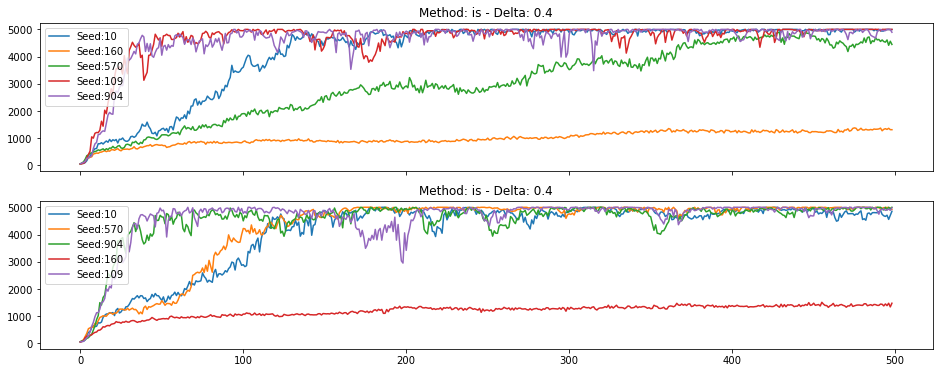

In [6]:
N = 2
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,N*3), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2', 0.4), 
                                              ('is', 'max-d2-harmonic', 0.4),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 1
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

----------------------------------------
Method: is  - Delta: 0.1
Experiments: 5
Seeds: 904, 570, 160, 10, 109
----------------------------------------
Method: is  - Delta: 0.2
Experiments: 5
Seeds: 570, 10, 904, 109, 160
----------------------------------------
Method: is  - Delta: 0.3
Experiments: 5
Seeds: 109, 570, 160, 904, 10
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 25
Seeds: 109, 570, 10, 160, 904, 42, 545, 947, 315, 236, 8, 100, 178, 689, 153, 712, 247, 746, 245, 963, 481, 307, 15, 662, 950
----------------------------------------
Method: is  - Delta: 0.5
Experiments: 5
Seeds: 10, 109, 570, 904, 160


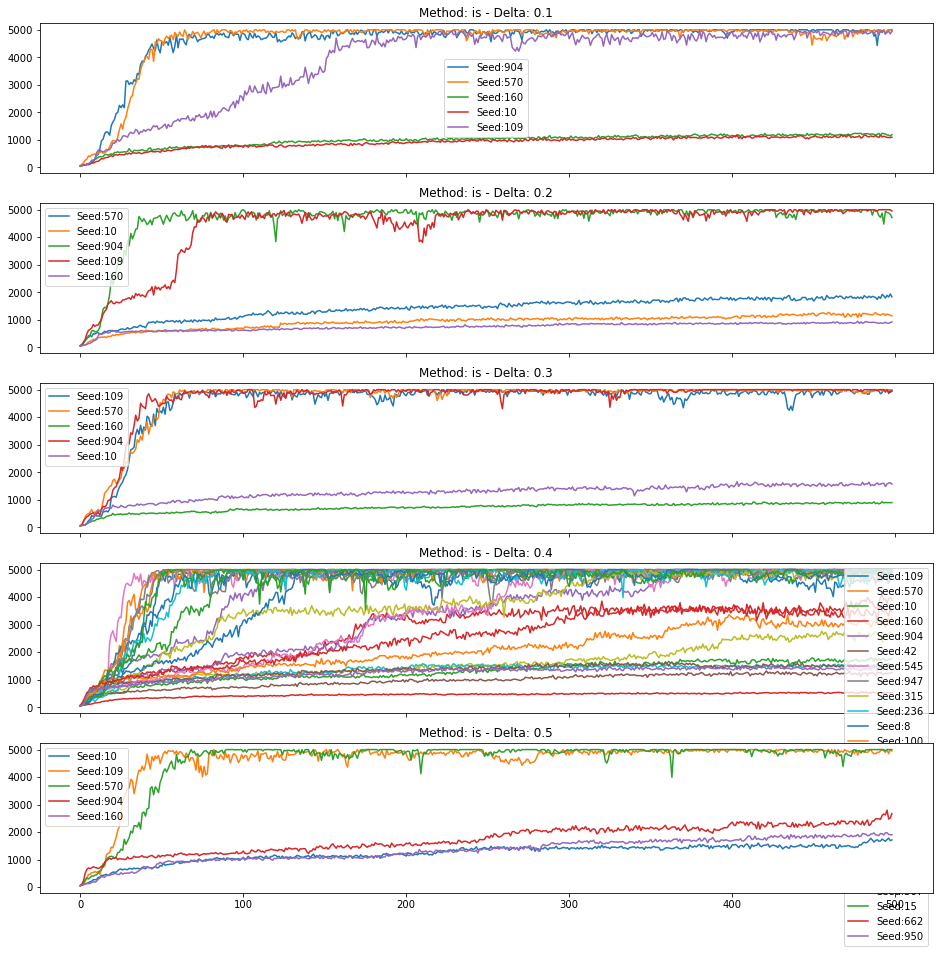

In [7]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

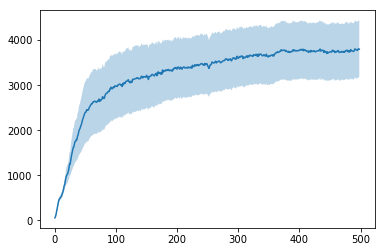

Seeds: 109, 570, 10, 160, 904, 42, 545, 947, 315, 236, 8, 100, 178, 689, 153, 712, 247, 746, 245, 963, 481, 307, 15, 662, 950


In [8]:
query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'is',
        'config.delta': 0.4,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Inverted double pendulum

----------------------------------------
Method: is  - Delta: 0.1
Experiments: 5
Seeds: 109, 160, 904, 10, 570
----------------------------------------
Method: is  - Delta: 0.2
Experiments: 5
Seeds: 570, 109, 160, 10, 904
----------------------------------------
Method: is  - Delta: 0.3
Experiments: 25
Seeds: 109, 160, 904, 570, 10, 545, 746, 15, 712, 42, 245, 689, 307, 315, 481, 8, 947, 950, 247, 662, 100, 178, 236, 153, 963
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 160, 109, 10, 904, 570
----------------------------------------
Method: is  - Delta: 0.5
Experiments: 5
Seeds: 570, 904, 10, 109, 160
----------------------------------------
Method: is  - Delta: 0.6
Experiments: 5
Seeds: 570, 904, 109, 160, 10
----------------------------------------
Method: is  - Delta: 0.7
Experiments: 5
Seeds: 904, 10, 109, 160, 570
----------------------------------------
Method: is  - Delta: 0.8
Experiments: 5
Seeds: 10, 570, 160, 109, 904
---------------

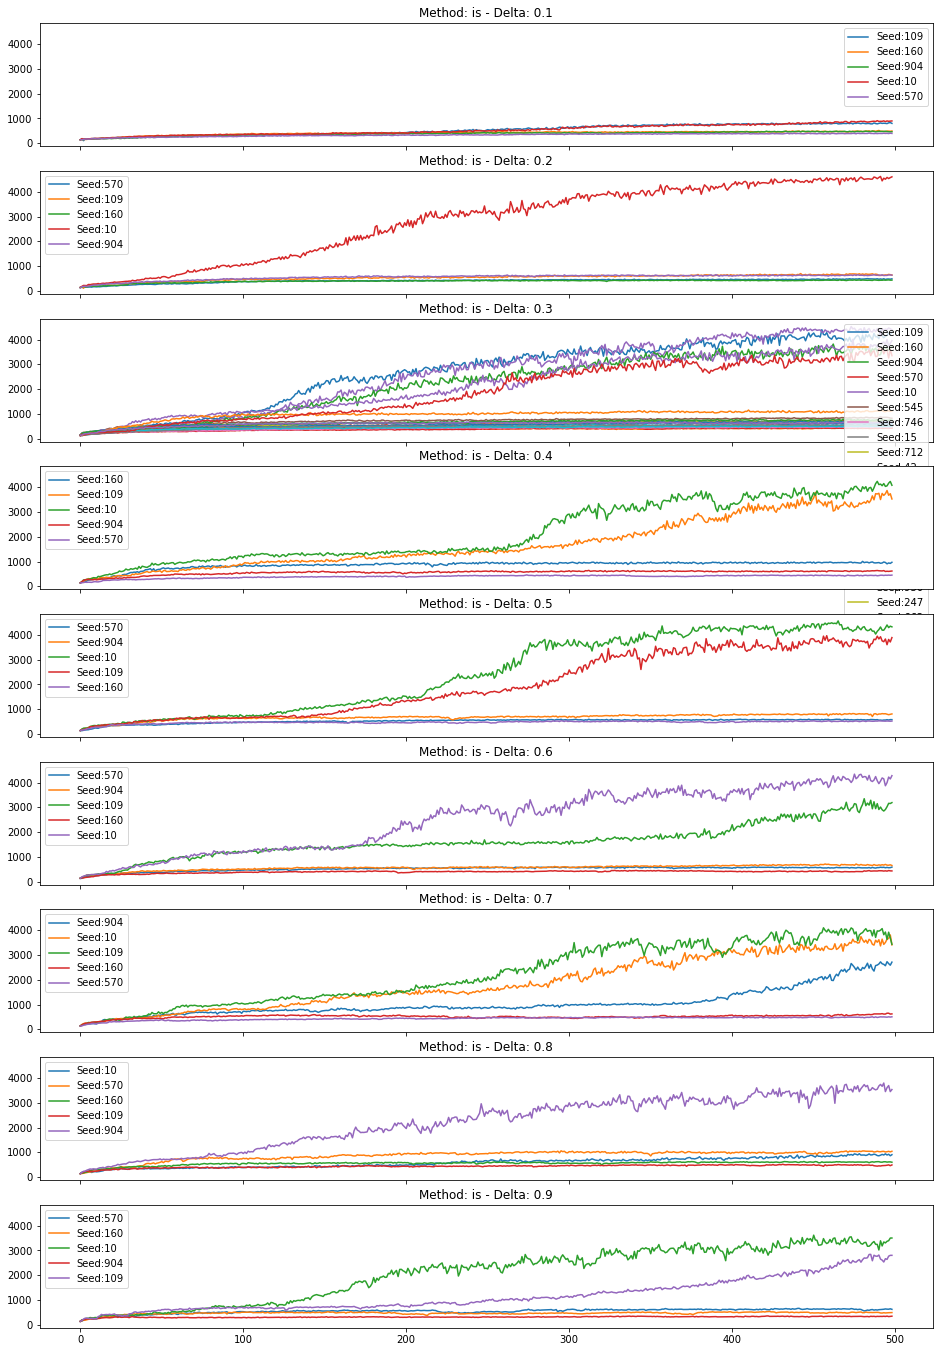

In [9]:
fig, axis = plt.subplots(nrows=9, ncols=1, figsize=(16,24), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.6),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.8),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-double-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

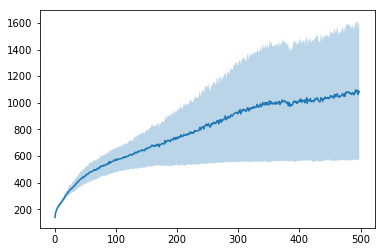

Seeds: 545, 746, 15, 712, 42, 245, 689, 307, 315, 481, 8, 947, 950, 247, 662, 100, 178, 236, 153, 963


In [10]:
query = {
        'config.env': 'rllab.inverted-double-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.3,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Inverted pendulum

----------------------------------------
Method: is  - Delta: 0.3
Experiments: 5
Seeds: 570, 10, 904, 160, 109
----------------------------------------
Method: is  - Delta: 0.6
Experiments: 5
Seeds: 160, 10, 904, 109, 570
----------------------------------------
Method: is  - Delta: 0.9
Experiments: 5
Seeds: 570, 109, 10, 904, 160
----------------------------------------
Method: is  - Delta: 0.99
Experiments: 5
Seeds: 10, 570, 904, 109, 160
----------------------------------------
Method: is  - Delta: 0.9999
Experiments: 5
Seeds: 109, 570, 904, 10, 160


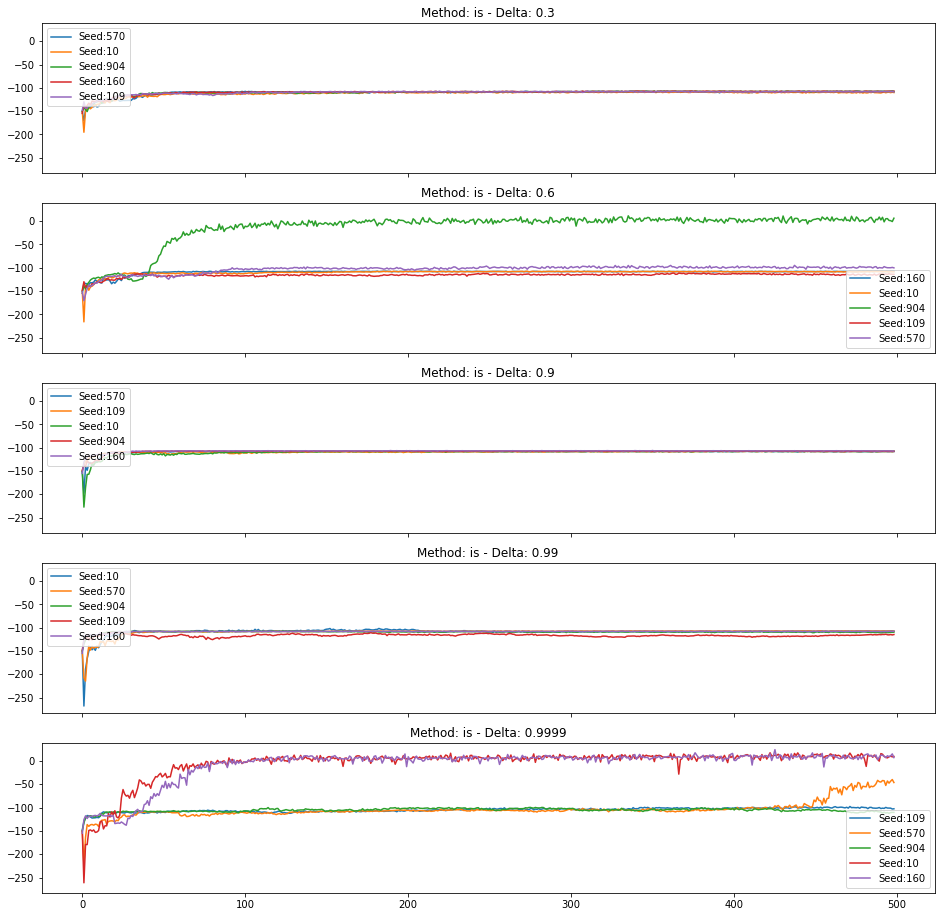

In [11]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.3), 
                                              ('is', 'max-d2-harmonic', 0.6),
                                              ('is', 'max-d2-harmonic', 0.9),
                                              ('is', 'max-d2-harmonic', 0.99),
                                              ('is', 'max-d2-harmonic', 0.9999),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, mis_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

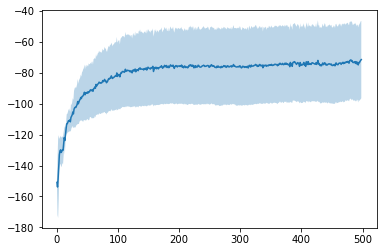

Seeds: 15, 545, 178, 712, 689, 746, 307, 662, 153, 950, 315, 245, 236, 42, 481, 963, 947, 8, 100, 247


In [12]:
query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9999,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Acrobot

----------------------------------------
Method: is  - Delta: 0.1
Experiments: 5
Seeds: 109, 160, 570, 904, 10
----------------------------------------
Method: is  - Delta: 0.3
Experiments: 5
Seeds: 570, 904, 10, 160, 109
----------------------------------------
Method: is  - Delta: 0.5
Experiments: 25
Seeds: 904, 570, 712, 689, 481, 109, 178, 245, 42, 963, 307, 10, 545, 100, 662, 247, 950, 15, 8, 160, 153, 746, 236, 315, 947
----------------------------------------
Method: is  - Delta: 0.7
Experiments: 5
Seeds: 160, 109, 10, 570, 904
----------------------------------------
Method: is  - Delta: 0.9
Experiments: 5
Seeds: 570, 160, 904, 10, 109


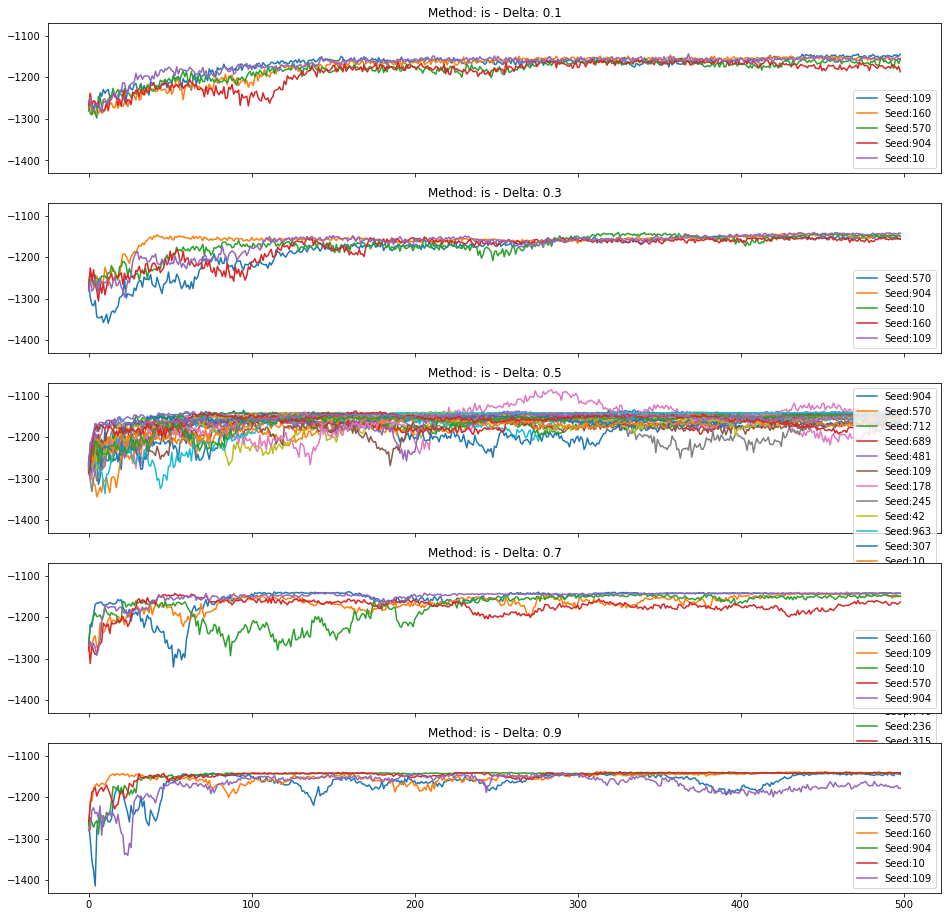

In [13]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.acrobot',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

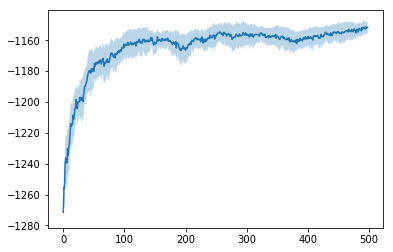

Seeds: 904, 570, 712, 689, 481, 109, 178, 245, 42, 963, 307, 10, 545, 100, 662, 247, 950, 15, 8, 160, 153, 746, 236, 315, 947


In [14]:
query = {
        'config.env': 'rllab.acrobot',
        'config.iw_method': 'is',
        'config.delta': 0.5,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Mountain car

----------------------------------------
Method: is  - Delta: 0.6
Experiments: 5
Seeds: 904, 109, 570, 10, 160
----------------------------------------
Method: is  - Delta: 0.8
Experiments: 5
Seeds: 109, 904, 570, 160, 10
----------------------------------------
Method: is  - Delta: 0.9
Experiments: 25
Seeds: 904, 109, 307, 178, 963, 746, 315, 545, 712, 481, 100, 662, 570, 950, 247, 160, 245, 153, 10, 689, 8, 15, 947, 42, 236
----------------------------------------
Method: is  - Delta: 0.99
Experiments: 5
Seeds: 570, 160, 109, 10, 904
----------------------------------------
Method: is  - Delta: 1.0
Experiments: 5
Seeds: 109, 904, 10, 160, 570


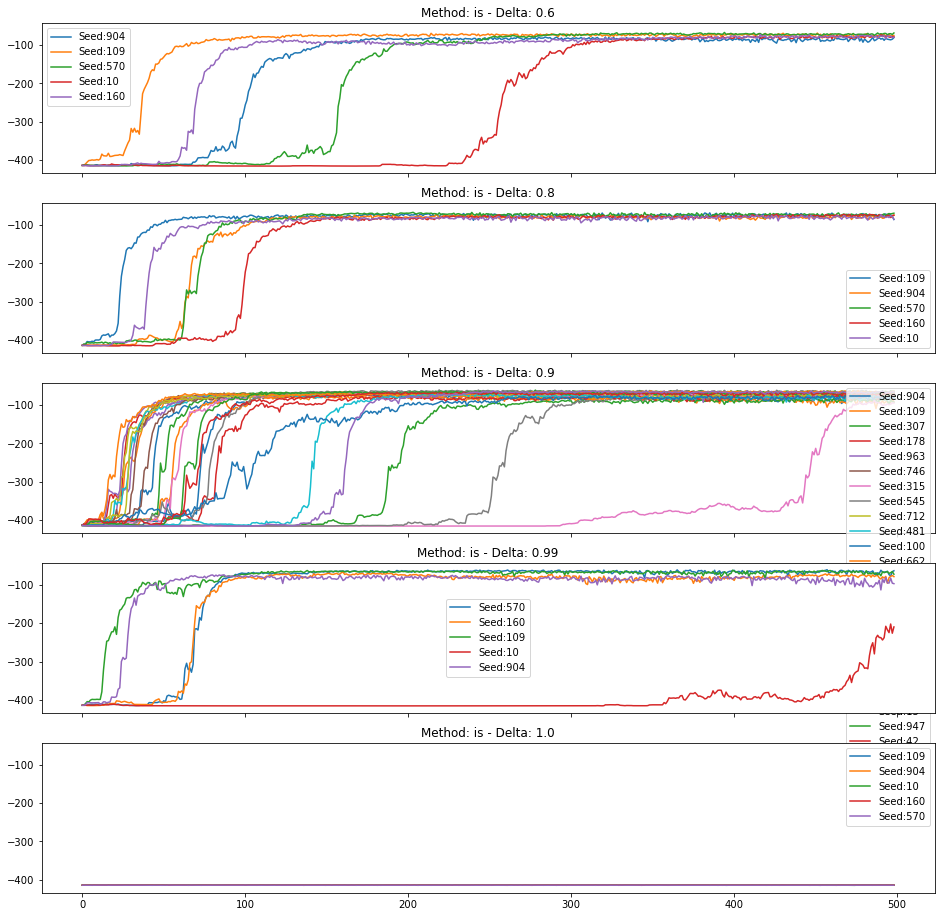

In [15]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.6), 
                                              ('is', 'max-d2-harmonic', 0.8),
                                              ('is', 'max-d2-harmonic', 0.9),
                                              ('is', 'max-d2-harmonic', 0.99),
                                              ('is', 'max-d2-harmonic', 1.0),
                                            ]):
    query = {
        'config.env': 'rllab.mountain-car',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

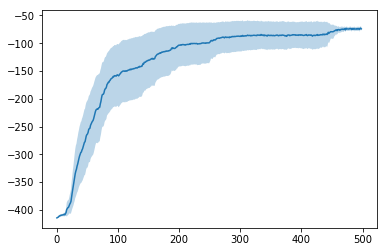

Seeds: 904, 109, 307, 178, 963, 746, 315, 545, 712, 481, 100, 662, 570, 950, 247, 160, 245, 153, 10, 689, 8, 15, 947, 42, 236


In [16]:
query = {
        'config.env': 'rllab.mountain-car',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))